In [44]:
import warnings

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
% matplotlib notebook

import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Trace_ELBO
from numpyro.contrib.einstein import kernels, Stein
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer.initialization import init_with_noise, init_to_value
from numpyro.contrib.callbacks import Progbar

UsageError: Line magic function `%` not found.


In [46]:
rng_key = jax.random.PRNGKey(142)
num_iterations = 6000

target_dist = dist.MultivariateNormal(loc=jnp.array([5., 10.]), covariance_matrix=[[3., 5.], [5., 10.]])

In [47]:
def model():
    numpyro.sample('x', target_dist)


## RBF Kernel

In [48]:
guide = AutoDelta(model)
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), Trace_ELBO(),
             kernels.RBFKernel(mode='vector'),
             init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([-10., 30.])}), noise_scale=1.0),
             num_particles=100)
svgd_state = svgd.init(rng_key)
init_loc = svgd.get_params(svgd_state)['x_auto_loc'].T

svgd_state, loss = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])
rbf_kernel_loc = svgd.get_params(svgd_state)['x_auto_loc'].T

Stein 3.6316: 100%|██████████| 6000/6000 [00:26<00:00, 230.29it/s]


## Graphical Kernel

In [49]:
guide = AutoDelta(model)
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), Trace_ELBO(), kernels.GraphicalKernel(),
             init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([-10., 30.])}), noise_scale=1.0),
             num_particles=100)
svgd_state = svgd.init(rng_key)
svgd_state, loss = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])
graphical_kernel_loc = svgd.get_params(svgd_state)['x_auto_loc'].T

Stein 3.5967: 100%|██████████| 6000/6000 [00:26<00:00, 227.35it/s]


/tmp/ipykernel_9677/1460337686.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


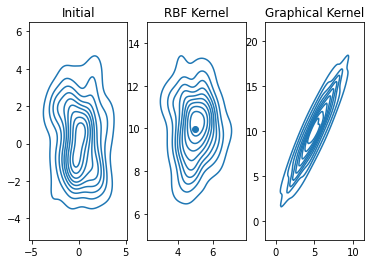

In [50]:
fig, axs = plt.subplots(ncols=3)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sns.kdeplot(*init_loc, ax=axs[0])
    axs[0].set_title('Initial')
    sns.kdeplot(*rbf_kernel_loc, ax=axs[1])
    axs[1].scatter(*rbf_kernel_loc.mean(1).copy())
    axs[1].set_title('RBF Kernel')
    sns.kdeplot(*graphical_kernel_loc, ax=axs[2])
    axs[2].set_title('Graphical Kernel')

fig.show()